# Unsupervised Learning Case Study: Mental Health in Technology-related jobs

## Unsupervised Machine Learning and Data Analysis

This notebook is devoted to utilizing Unsupervised Machine Learning techniques to analyse the cleaned Mental Health in Technology-related jobs dataset. <br>
The encoded, scaled, and labeled data will be saved as tech_df_encoded_scaled_clustered.csv.

### Notebook Objectives:
1. Encode data using One-Hot-Encoding and Ordinal Encoding
2. Scale data
3. Perform PCA (Principal Component Analysis) for dimensionality reduction
4. Explore first and second principal components for feature influence
5. Fit K-Means
6. Evaluate and analyse clusters


In [281]:

# Set the environment to limit MKL threads
import os

os.environ['OMP_NUM_THREADS']= '5'

In [282]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE
import numpy as np
import textwrap

#### Step 1: Load Cleaned Data Set

In [283]:
# Load Data
data = pd.read_csv('tech_df_cleaned.csv', index_col=None)
data.describe(include='all')

,number_of_employees,tech_company,mental_health_benefits,mental_health_coverage_awareness,mental_health_official_communication,mental_health_resources,mental_health_anonymity,asking_for_leave_for_mental_health,discussing_mental_health_with_employer,discussing_physical_health_with_employer,...,at_any_point_diagnosed_MH_disorder,treatment_MH_disorder,interference_with_work_with_effective_treatment,interference_with_work_NOT_effective_treatment,gender,continent_residence,continent_work,work_position,remote_work,age_group
count,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146,...,1146,1146,1146,1146,1146,1146,1146,1146,1146,1146
unique,6,2,4,4,3,3,3,6,3,3,...,2,2,5,5,3,7,7,180,3,6
top,26-100,Yes,Yes,No,No,No,I don't know,Somewhat easy,Maybe,No,...,No,Yes,Not applicable to me,Often,Male,North America,North America,Back-end Developer,Sometimes,30-39
freq,292,883,531,354,813,531,742,281,487,837,...,579,657,455,422,846,774,779,238,611,543


#### Step 2: Encode each feature using most appropriate encoder: 

- OneHotEncoder
    - Nominal Features: binary and categorical features without implied order
- MultiLabelBinarizer
    - Nominal Features: features with multiple categories per participant entry
- OrdinalEncoder
    - Ordinal Features: natural order

In [284]:
# Create a data frame to show all features and their unique values. 
# This will help to determine which features to encode using OneHotEncoder, MultiLabelBinarizer, or OrdinalEncoder.

unique_categories = {}

for column in data.columns:
    unique_categories[column] = data[column].unique()
    
# Convert dictionary to data frame
unique_categories_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in unique_categories.items() ]))

# Display data frame
unique_categories_df



,number_of_employees,tech_company,mental_health_benefits,mental_health_coverage_awareness,mental_health_official_communication,mental_health_resources,mental_health_anonymity,asking_for_leave_for_mental_health,discussing_mental_health_with_employer,discussing_physical_health_with_employer,...,at_any_point_diagnosed_MH_disorder,treatment_MH_disorder,interference_with_work_with_effective_treatment,interference_with_work_NOT_effective_treatment,gender,continent_residence,continent_work,work_position,remote_work,age_group
0,26-100,Yes,Not eligible for coverage / N/A,Missing,No,No,I don't know,Very easy,No,No,...,Yes,No,Not applicable to me,Not applicable to me,Male,Europe,Europe,Back-end Developer,Sometimes,30-39
1,6-25,No,No,Yes,Yes,Yes,Yes,Somewhat easy,Maybe,Maybe,...,No,Yes,Rarely,Sometimes,Female,North America,North America,Back-end Developer|Front-end Developer,Never,20-29
2,More than 1000,NaN,Yes,I am not sure,I don't know,I don't know,No,Neither easy nor difficult,Yes,Yes,...,NaN,NaN,Sometimes,Often,Other/Non-Binary,Oceania,Oceania,Executive Leadership|Supervisor/Team Lead|Dev ...,Always,40-49
3,100-500,NaN,I don't know,No,NaN,NaN,NaN,Very difficult,NaN,NaN,...,NaN,NaN,Never,Rarely,NaN,South America,South America,DevOps/SysAdmin|Support|Back-end Developer|Fro...,NaN,50-59
4,500-1000,NaN,NaN,NaN,NaN,NaN,NaN,Somewhat difficult,NaN,NaN,...,NaN,NaN,Often,Never,NaN,Asia,Asia,Dev Evangelist/Advocate|Back-end Developer,NaN,< 20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Support|Back-end Developer|Front-end Developer...,NaN,NaN
176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dev Evangelist/Advocate|DevOps/SysAdmin|Suppor...,NaN,NaN
177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other|Supervisor/Team Lead|Dev Evangelist/Advo...,NaN,NaN
178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Supervisor/Team Lead|Back-end Developer|Designer,NaN,NaN


In [285]:
# Create a dictionary of ordinal features and their categories
# Make sure order of categories is consistent with the natural order of the feature

ordinal_features_categories = {
    'number_of_employees': ['1-5', '6-25', '26-100', '100-500', '500-1000', 'More than 1000'], 
    'asking_for_leave_for_mental_health':["I don't know", "Very difficult", "Somewhat difficult", "Neither easy nor difficult", "Somewhat easy", "Very easy"], 
    'previous_employer_mental_health_benefits': ["No Previous Employer", "I don't know", "No, none did", "Some did", "Yes, they all did"],
    'previous_employer_mental_health_coverage_awareness':["No Previous Employer", "N/A (not currently aware)", "No, I only became aware later","I was aware of some", "Yes, I was aware of all of them"], 
    'previous_employer_mental_health_official_communication': ["No Previous Employer", "I don't know", "None did", "Some did", "Yes, they all did"],
    'previous_employer_mental_health_resources': ["No Previous Employer", "None did", "Some did", "Yes, they all did"],
    'previous_employer_mental_health_anonymity': ["No Previous Employer", "I don't know", "No", "Sometimes", "Yes, always"],
    'discussing_mental_health_with_previous_employer': ["No Previous Employer", "I don't know", "None of them", "Some of them", "Yes, all of them"],
    'discussing_physical_health_with_previous_employer': ["No Previous Employer", "None of them", "Some of them", "Yes, all of them"],
    'reveal_mental_diagnoses_previous_coworkers': ['No Previous Employer', 'No, at none of my previous employers', 'Some of my previous employers', 'Yes, at all of my previous employers'],
    'reveal_mental_diagnoses_previous_supervisor':['No Previous Employer', "I don't know", 'No, at none of my previous employers', 'Some of my previous employers', 'Yes, at all of my previous employers'],
    'previous_employer_physical_same_mental':["No Previous Employer","I don't know", "None did", "Some did", "Yes, they all did"],
    'previous_employer_neg_consequences_open_mental_health':["No Previous Employer", "None of them", "Some of them", "Yes, all of them"],
    'share_mental_illness_loved_ones':["Not applicable to me (I do not have a mental illness)", "Not open at all", "Somewhat not open", "Neutral",  "Somewhat open", "Very open"],
    'interference_with_work_with_effective_treatment': ['Not applicable to me', 'Never', 'Rarely', 'Sometimes', 'Often'],
    'interference_with_work_NOT_effective_treatment': ['Not applicable to me', 'Never', 'Rarely', 'Sometimes', 'Often'],
    'age_group': ['< 20', '20-29', '30-39', '40-49', '50-59', '60+'],
    'remote_work':['Never', 'Sometimes', 'Always'],
    'discussing_mental_health_with_employer': ['No', 'Maybe','Yes'],
    'discussing_physical_health_with_employer': ['No', 'Maybe','Yes'],
    'discussing_mental_health_with_coworker': ['No', 'Maybe','Yes'],
    'discussing_mental_health_with_supervisor': ['No', 'Maybe','Yes'],
    'physical_health_interview': ['No', 'Maybe','Yes'],
    'mental_health_interview': ['No', 'Maybe','Yes'],
    'current_employment_less_likely_to_reveal_mental_health_issue':['Missing', 'No', 'Maybe','Yes'],
    'past_history_mental_health': ['No', 'Maybe','Yes'],
    'current_MH_disorder': ['No', 'Maybe','Yes']
}

# Initialize OrdinalEncoder with categories from ordinal_features dictionary
ordinal_encoder = OrdinalEncoder(categories=list(ordinal_features_categories.values()))

# Fit and transform data the ordinal features

ordinal_encoded = ordinal_encoder.fit_transform(data[list(ordinal_features_categories.keys())])

ordinal_encoded_data = pd.DataFrame(ordinal_encoded, columns=list(ordinal_features_categories.keys()))
ordinal_encoded_data.head()


,number_of_employees,asking_for_leave_for_mental_health,previous_employer_mental_health_benefits,previous_employer_mental_health_coverage_awareness,previous_employer_mental_health_official_communication,previous_employer_mental_health_resources,previous_employer_mental_health_anonymity,discussing_mental_health_with_previous_employer,discussing_physical_health_with_previous_employer,reveal_mental_diagnoses_previous_coworkers,...,remote_work,discussing_mental_health_with_employer,discussing_physical_health_with_employer,discussing_mental_health_with_coworker,discussing_mental_health_with_supervisor,physical_health_interview,mental_health_interview,current_employment_less_likely_to_reveal_mental_health_issue,past_history_mental_health,current_MH_disorder
0,2.0,5.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0,2.0,...,1.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,2.0,0.0
1,1.0,4.0,4.0,3.0,2.0,2.0,4.0,2.0,1.0,1.0,...,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,2.0,2.0
2,1.0,3.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,...,2.0,1.0,0.0,1.0,1.0,2.0,2.0,3.0,1.0,0.0
3,1.0,3.0,1.0,1.0,3.0,1.0,1.0,3.0,2.0,1.0,...,1.0,2.0,1.0,1.0,0.0,1.0,0.0,3.0,2.0,2.0
4,5.0,4.0,2.0,4.0,2.0,1.0,1.0,4.0,2.0,1.0,...,1.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,0.0,2.0


In [286]:
# Add encoded data to original data frame and drop original ordinal features

data = pd.concat([data.drop(columns=list(ordinal_features_categories.keys())), ordinal_encoded_data], axis=1)

In [287]:
# Use MultiLabelBinarizer to encode work_position while some participants have multiple roles separated by '|'.

one_hot_multiclass = MultiLabelBinarizer()
data_encoded = one_hot_multiclass.fit_transform(data['work_position'].str.split('|'))
data = pd.concat([data.drop(columns=['work_position']), pd.DataFrame(data_encoded, columns=one_hot_multiclass.classes_)], axis=1)
data.head()



,tech_company,mental_health_benefits,mental_health_coverage_awareness,mental_health_official_communication,mental_health_resources,mental_health_anonymity,physical_same_mental,neg_consequences_open_mental_health,previous_employer,mental_health_career_impact,...,Dev Evangelist/Advocate,DevOps/SysAdmin,Executive Leadership,Front-end Developer,HR,One-person shop,Other,Sales,Supervisor/Team Lead,Support
0,Yes,Not eligible for coverage / N/A,Missing,No,No,I don't know,I don't know,No,Yes,Maybe,...,0,0,0,0,0,0,0,0,0,0
1,Yes,No,Yes,Yes,Yes,Yes,Yes,No,Yes,"No, I don't think it would",...,0,0,0,1,0,0,0,0,0,0
2,Yes,No,Missing,No,No,I don't know,I don't know,No,Yes,Maybe,...,0,0,0,0,0,0,0,0,0,0
3,No,Yes,Yes,No,No,No,No,No,Yes,"Yes, I think it would",...,1,1,1,1,0,0,0,0,1,1
4,Yes,Yes,I am not sure,No,Yes,Yes,No,Yes,Yes,"Yes, I think it would",...,0,1,0,1,0,0,0,0,0,1


In [288]:
# Use OneHotEncoder to encode the rest of the categorical variables
# If binary, drop one of the columns to avoid multicollinearity

categorical_columns = data.select_dtypes(include='object').columns.tolist()
encoder = OneHotEncoder(sparse_output=False, drop='if_binary')

one_hot_encoded = encoder.fit_transform(data[categorical_columns])
one_hot_data =pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
data = pd.concat([data.drop(columns=categorical_columns), one_hot_data], axis=1)

data.head()


,number_of_employees,asking_for_leave_for_mental_health,previous_employer_mental_health_benefits,previous_employer_mental_health_coverage_awareness,previous_employer_mental_health_official_communication,previous_employer_mental_health_resources,previous_employer_mental_health_anonymity,discussing_mental_health_with_previous_employer,discussing_physical_health_with_previous_employer,reveal_mental_diagnoses_previous_coworkers,...,continent_residence_Other,continent_residence_South Africa,continent_residence_South America,continent_work_Asia,continent_work_Europe,continent_work_North America,continent_work_Oceania,continent_work_Other,continent_work_South Africa,continent_work_South America
0,2.0,5.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,4.0,4.0,3.0,2.0,2.0,4.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,3.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,3.0,1.0,1.0,3.0,1.0,1.0,3.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5.0,4.0,2.0,4.0,2.0,1.0,1.0,4.0,2.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


#### Step 3: Scale all features to the same range. 

Note: 

Prior to final selection of MinMaxScaler and current parameters for PCA (n_components = 13) and K_means(k=3) additional methods were trialed: 

1. Variance Threshold
2. Feature Interactions using Polynomial Features
3. RobustScaler
4. One-Hot Encoding Only (No Ordinal Encoding)
5. Perform One-Hot Encoding Only on top 3 frequent categories
    -Worsening of Silhouette Score
5. K-Means ++ vs. Random for initial seed selection
6. PCA n_components vs. Silhouette 
    - (lower n_components higher silhouette by 0.02-0.06 however explains less variance)
        - Find a balance between explained variance and silhouette score
7. Silhouette score is worse with 4 clusters than 3 clusters
    - K = 2 has a silhouette score of 0.136
    - K = 3 has a silhouette score of 0.133
    - K = 4 has a silhouette score of 0.114

In [289]:
# Scale all features using MinMaxScaler to maintain the 0-1 range given One-Hot Encoded features

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
data = pd.DataFrame(data_scaled, columns=data.columns)
data.head()

# Add index to the data frame

data.reset_index(drop=True)

,number_of_employees,asking_for_leave_for_mental_health,previous_employer_mental_health_benefits,previous_employer_mental_health_coverage_awareness,previous_employer_mental_health_official_communication,previous_employer_mental_health_resources,previous_employer_mental_health_anonymity,discussing_mental_health_with_previous_employer,discussing_physical_health_with_previous_employer,reveal_mental_diagnoses_previous_coworkers,...,continent_residence_Other,continent_residence_South Africa,continent_residence_South America,continent_work_Asia,continent_work_Europe,continent_work_North America,continent_work_Oceania,continent_work_Other,continent_work_South Africa,continent_work_South America
0,0.4,1.0,0.50,0.25,0.25,0.333333,0.25,0.75,0.333333,0.666667,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.2,0.8,1.00,0.75,0.50,0.666667,1.00,0.50,0.333333,0.333333,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.2,0.6,0.50,0.25,0.50,0.666667,0.25,0.25,0.666667,0.666667,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.2,0.6,0.25,0.25,0.75,0.333333,0.25,0.75,0.666667,0.333333,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.8,0.50,1.00,0.50,0.333333,0.25,1.00,0.666667,0.333333,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141,0.6,0.8,0.25,0.25,0.25,0.666667,0.25,0.75,0.666667,0.666667,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1142,0.8,0.8,0.75,0.75,0.50,0.333333,0.25,0.75,0.333333,0.666667,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1143,0.6,0.4,0.75,0.75,0.50,0.666667,0.75,1.00,0.666667,0.666667,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1144,0.6,0.4,0.50,0.25,0.50,0.333333,0.25,1.00,0.333333,0.333333,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#### Step 4: Perform dimensionality reduction using PCA and assess top 15 contributory features of PC1 and PC2

In [290]:
# Dimensionality Reduction with PCA

pca= PCA(n_components=13)
pca_data = pca.fit_transform(data)
pca_data.shape

(1146, 13)

In [291]:
# Variance explained by each principal component

var_exp = pca.explained_variance_ratio_
cum_var_exp = var_exp.cumsum()
var_exp, cum_var_exp

(array([0.10824374, 0.07979794, 0.06296821, 0.0497912 , 0.04274528,
        0.0348519 , 0.03332077, 0.02979355, 0.0280568 , 0.02476317,
        0.02415667, 0.0229762 , 0.02234213]),
 array([0.10824374, 0.18804168, 0.25100988, 0.30080109, 0.34354637,
        0.37839827, 0.41171904, 0.44151258, 0.46956938, 0.49433255,
        0.51848922, 0.54146542, 0.56380754]))

In [292]:
# Understand the importance of each feature in the first principal component

pca_components = pd.DataFrame(pca.components_, columns=data.columns)
first_component = pca_components.iloc[0]
first_component = first_component.sort_values(ascending=False)
first_component



at_any_point_diagnosed_MH_disorder_Yes                                   0.304277
treatment_MH_disorder_Yes                                                0.297311
past_history_mental_health                                               0.273435
interference_with_work_NOT_effective_treatment                           0.254591
current_MH_disorder                                                      0.251192
                                                                           ...   
current_or_previous_employment_unsupportive_response_mental_health_No   -0.134224
gender_Male                                                             -0.134587
continent_work_Europe                                                   -0.179288
continent_residence_Europe                                              -0.182788
family_history_mental_health_No                                         -0.210306
Name: 0, Length: 99, dtype: float64

In [293]:
# Understand the importance of each feature in the second principal component

pca_components = pd.DataFrame(pca.components_, columns=data.columns)
second_component = pca_components.iloc[1]
second_component = second_component.sort_values(ascending=False)
second_component

physical_same_mental_Yes                                         0.262715
discussing_mental_health_with_supervisor                         0.257069
mental_health_anonymity_Yes                                      0.222149
discussing_mental_health_with_coworker                           0.208094
mental_health_benefits_Yes                                       0.194157
                                                                   ...   
mental_health_resources_No                                      -0.226091
mental_health_official_communication_No                         -0.226128
coworkers_perception_of_mental_health_Yes, I think they would   -0.230975
discussing_mental_health_with_employer                          -0.236709
mental_health_career_impact_Yes, I think it would               -0.251363
Name: 1, Length: 99, dtype: float64

In [294]:
# Select only the top 15 features that contribute to the first principal component to be used for Exploratory Data Analysis later

top_15_features_PC1 = first_component.head(15)
top_15_features_PC1

at_any_point_diagnosed_MH_disorder_Yes                          0.304277
treatment_MH_disorder_Yes                                       0.297311
past_history_mental_health                                      0.273435
interference_with_work_NOT_effective_treatment                  0.254591
current_MH_disorder                                             0.251192
family_history_mental_health_Yes                                0.230769
mental_health_benefits_Yes                                      0.213503
continent_residence_North America                               0.210792
continent_work_North America                                    0.206707
mental_health_coverage_awareness_Yes                            0.181574
interference_with_work_with_effective_treatment                 0.168298
previous_employer_mental_health_coverage_awareness              0.124779
previous_employer_mental_health_benefits                        0.120426
gender_Female                                      

In [295]:
# Select only the top 15 features that contribute to the second principal component to be used for Exploratory Data Analysis later

top_15_features_PC2 = second_component.head(15)
top_15_features_PC2

physical_same_mental_Yes                                                 0.262715
discussing_mental_health_with_supervisor                                 0.257069
mental_health_anonymity_Yes                                              0.222149
discussing_mental_health_with_coworker                                   0.208094
mental_health_benefits_Yes                                               0.194157
mental_health_resources_Yes                                              0.192430
mental_health_career_impact_Maybe                                        0.176678
mental_health_official_communication_Yes                                 0.168817
coworkers_perception_of_mental_health_No, I don't think they would       0.160589
asking_for_leave_for_mental_health                                       0.160417
current_or_previous_employment_unsupportive_response_mental_health_No    0.139180
mental_health_coverage_awareness_Yes                                     0.130180
mental_health_in

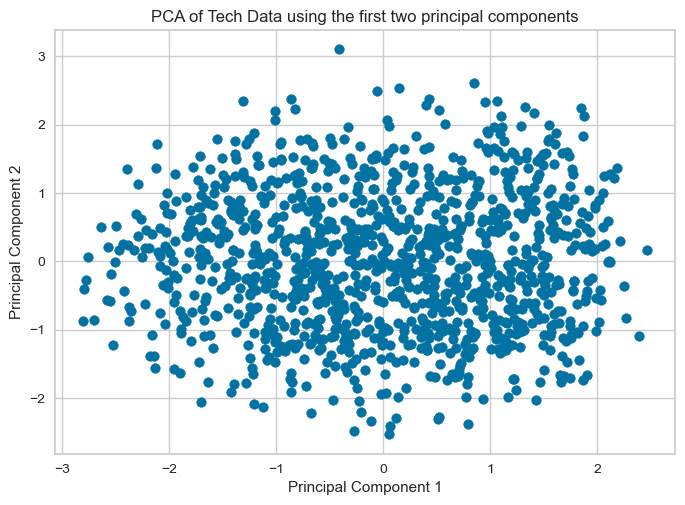

In [296]:
# Visualize the data in two dimensions using the first two principal components 

Y = PCA(n_components=2).fit_transform(data)
plt.scatter(Y[:, 0], Y[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Tech Data using the first two principal components')
plt.show()


#### Step 5: Assess optimum number of clusters using elbow method, silhouette score, and inertia to fit K-means model.

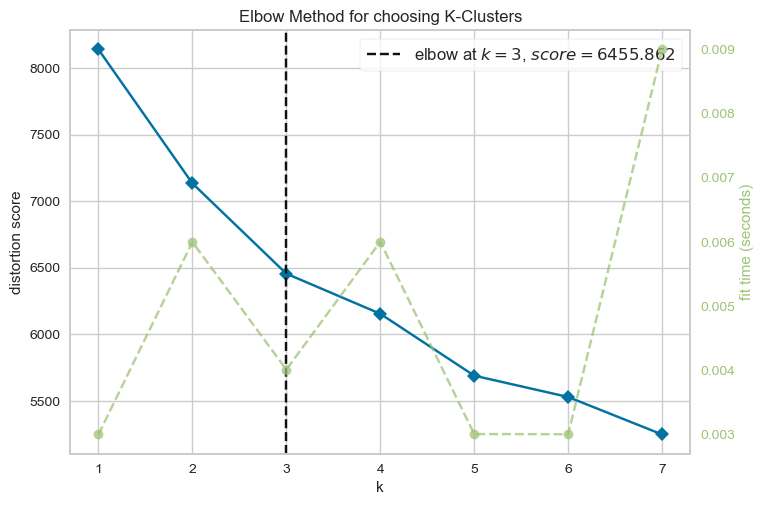

<Axes: title={'center': 'Elbow Method for choosing K-Clusters'}, xlabel='k', ylabel='distortion score'>

In [297]:
# Assess number of clusters using elbow method and reviewing Silhouette Score

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 8), timings=True)

# Fit the data to the visualizer
visualizer.fit(pca_data)
visualizer.title = 'Elbow Method for choosing K-Clusters'
visualizer.show()

# Oscillation of elbow method between 3 and 4 depending on initial seeds
# Tried K-Means ++ with worse fluctuation between 3-5

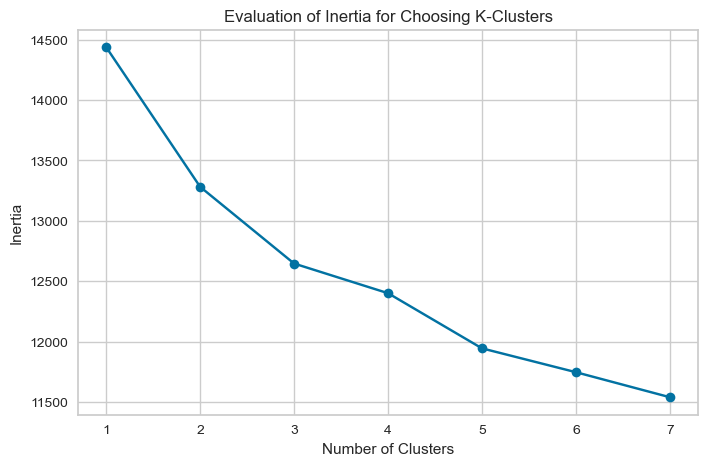

In [298]:
# Calculate inertia for varying numbers of clusters to determine the optimal number of clusters

# Define the range of clusters to test
cluster_range = range(1, 8)
inertia_values = []

# Calculate inertia for each number of clusters
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(data)
    inertia_values.append(kmeans.inertia_)

# Plot the inertia values
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Evaluation of Inertia for Choosing K-Clusters')
plt.show()

# Elbow point is at 3 clusters for Inertia

In [299]:
# Fit KMeans Model using optimal number of clusters chosen by balancing silhouette score, elbow method, and inertia.

kmeans = KMeans(n_clusters=3, random_state=0).fit(pca_data)

In [300]:
# Save cluster labels to encoded data set for feature importance testing

data['clusters'] = kmeans.labels_
data.head()

# Save the data to a csv file
data.to_csv('tech_df_encoded_scaled_clustered.csv', index=False)

# Drop column to finish remainder of processing

data = data.drop(columns=['clusters'])


#### Step 6: Use various methods to visualize and analyze data

1. Scatter plot to visualize PCA data
2. T-SNE to visualize PCA data
3. Silhouette score
4. Number of Data Points in Each cluster
5. Histogram of top features contributing to PCA
6. Pie Charts showing participant demographics

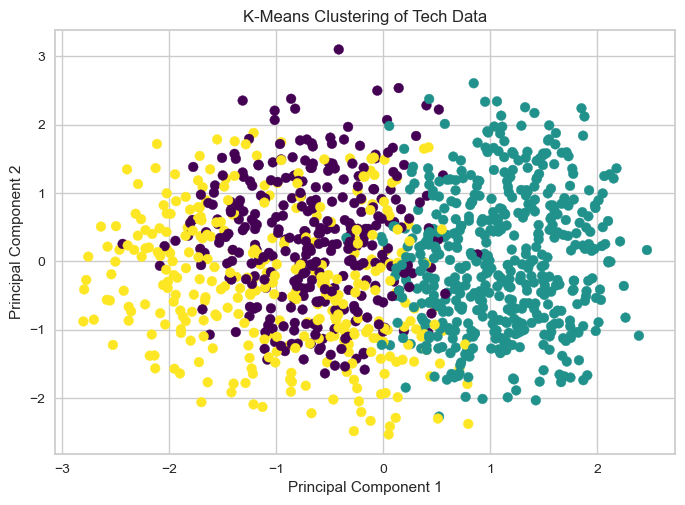

In [301]:
# Visualize the clusters in two dimensions

plt.scatter(Y[:, 0], Y[:, 1], c=kmeans.labels_, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering of Tech Data')

plt.show()

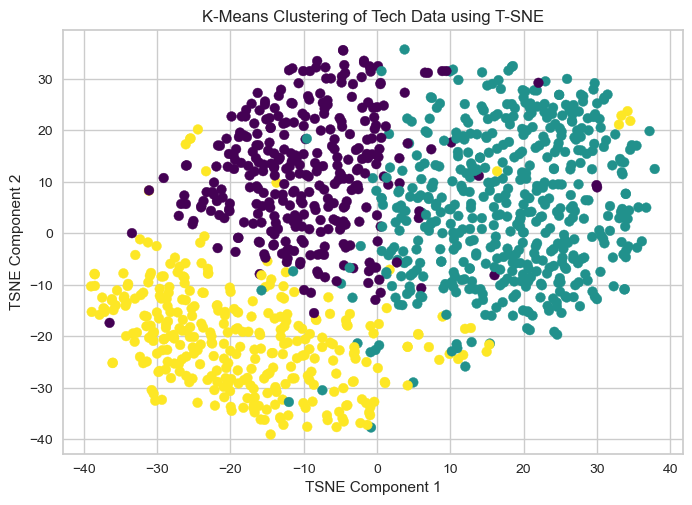

In [302]:
# Visualize the clusters from PCA data using T-SNE to better understand the clusters

tsne = TSNE(n_components=2, random_state=0)
tsne_data = tsne.fit_transform(data)
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=kmeans.labels_, cmap='viridis')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('K-Means Clustering of Tech Data using T-SNE')
plt.show()


In [303]:
# Inverse scale the data to get the original data

inverse_scale_data = scaler.inverse_transform(data)
data = pd.DataFrame(inverse_scale_data, columns=data.columns)

# Inverse transform data to back to original data frame format prior to OneHotEncoding, MultiLabelBinarizer, and OrdinalEncoder

# Inverse Transform One_Hot_Encoded Data
data = pd.concat([data.drop(columns=one_hot_data.columns), pd.DataFrame(encoder.inverse_transform(one_hot_data), columns=categorical_columns)], axis=1)

# Inverse Transform OrdinalEncoded Data
data = pd.concat([data.drop(columns=list(ordinal_features_categories.keys())), pd.DataFrame(ordinal_encoder.inverse_transform(ordinal_encoded), columns=list(ordinal_features_categories.keys()))], axis=1)

# Inverse transform MultiLabelBinarizer Rows and concatenate with original data set.

decoded_multi_data = one_hot_multiclass.inverse_transform(data[one_hot_multiclass.classes_].values)
data['work_position'] = ['|'.join(category) for category in decoded_multi_data]
data = data.drop(columns=one_hot_multiclass.classes_)

data.head()

,tech_company,mental_health_benefits,mental_health_coverage_awareness,mental_health_official_communication,mental_health_resources,mental_health_anonymity,physical_same_mental,neg_consequences_open_mental_health,previous_employer,mental_health_career_impact,...,discussing_mental_health_with_employer,discussing_physical_health_with_employer,discussing_mental_health_with_coworker,discussing_mental_health_with_supervisor,physical_health_interview,mental_health_interview,current_employment_less_likely_to_reveal_mental_health_issue,past_history_mental_health,current_MH_disorder,work_position
0,Yes,Not eligible for coverage / N/A,Missing,No,No,I don't know,I don't know,No,Yes,Maybe,...,No,No,Maybe,Yes,Maybe,Maybe,Missing,Yes,No,Back-end Developer
1,Yes,No,Yes,Yes,Yes,Yes,Yes,No,Yes,"No, I don't think it would",...,No,No,Maybe,Yes,Maybe,No,Missing,Yes,Yes,Back-end Developer|Front-end Developer
2,Yes,No,Missing,No,No,I don't know,I don't know,No,Yes,Maybe,...,Maybe,No,Maybe,Maybe,Yes,Yes,Yes,Maybe,No,Back-end Developer
3,No,Yes,Yes,No,No,No,No,No,Yes,"Yes, I think it would",...,Yes,Maybe,Maybe,No,Maybe,No,Yes,Yes,Yes,Back-end Developer|Dev Evangelist/Advocate|Dev...
4,Yes,Yes,I am not sure,No,Yes,Yes,No,Yes,Yes,"Yes, I think it would",...,Yes,Yes,Maybe,Yes,Yes,Maybe,No,No,Yes,Back-end Developer|Designer|DevOps/SysAdmin|Fr...


In [304]:
# Add cluster labels to the data frame based on index

data['cluster'] = kmeans.labels_
data.head()


,tech_company,mental_health_benefits,mental_health_coverage_awareness,mental_health_official_communication,mental_health_resources,mental_health_anonymity,physical_same_mental,neg_consequences_open_mental_health,previous_employer,mental_health_career_impact,...,discussing_physical_health_with_employer,discussing_mental_health_with_coworker,discussing_mental_health_with_supervisor,physical_health_interview,mental_health_interview,current_employment_less_likely_to_reveal_mental_health_issue,past_history_mental_health,current_MH_disorder,work_position,cluster
0,Yes,Not eligible for coverage / N/A,Missing,No,No,I don't know,I don't know,No,Yes,Maybe,...,No,Maybe,Yes,Maybe,Maybe,Missing,Yes,No,Back-end Developer,2
1,Yes,No,Yes,Yes,Yes,Yes,Yes,No,Yes,"No, I don't think it would",...,No,Maybe,Yes,Maybe,No,Missing,Yes,Yes,Back-end Developer|Front-end Developer,1
2,Yes,No,Missing,No,No,I don't know,I don't know,No,Yes,Maybe,...,No,Maybe,Maybe,Yes,Yes,Yes,Maybe,No,Back-end Developer,2
3,No,Yes,Yes,No,No,No,No,No,Yes,"Yes, I think it would",...,Maybe,Maybe,No,Maybe,No,Yes,Yes,Yes,Back-end Developer|Dev Evangelist/Advocate|Dev...,1
4,Yes,Yes,I am not sure,No,Yes,Yes,No,Yes,Yes,"Yes, I think it would",...,Yes,Maybe,Yes,Yes,Maybe,No,No,Yes,Back-end Developer|Designer|DevOps/SysAdmin|Fr...,2


In [305]:
# Calculate the overall Silhouette score

S= silhouette_score(pca_data, kmeans.labels_)
S


0.1334882908857456

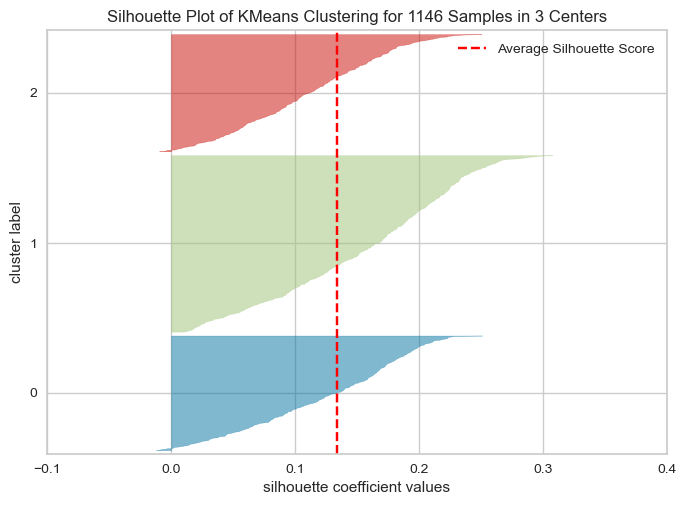

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 1146 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [306]:
# Generate, fit and show a Silhouette Visualizer

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(pca_data)
visualizer.show()

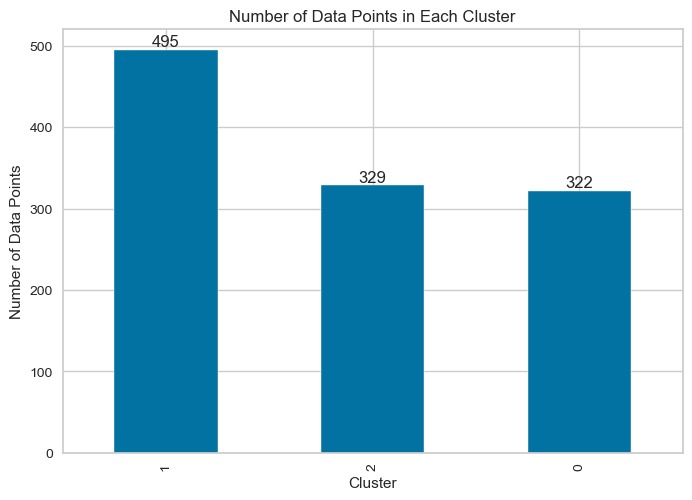

In [307]:
# Visualization of number of data points in each cluster, with the value counts of each cluster shown in a bar chart


ax = data['cluster'].value_counts().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points in Each Cluster')


# Annotate each bar with the count value
ax.bar_label(ax.containers[0])


plt.show()



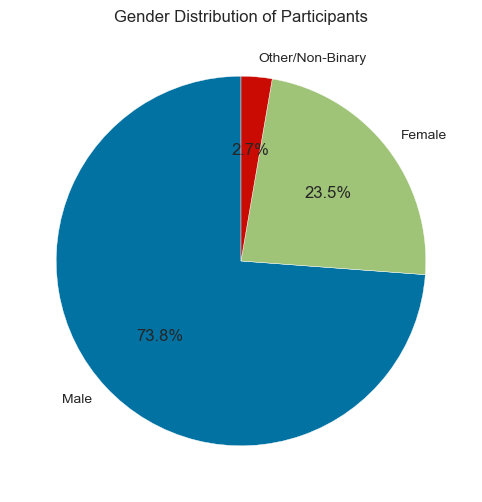

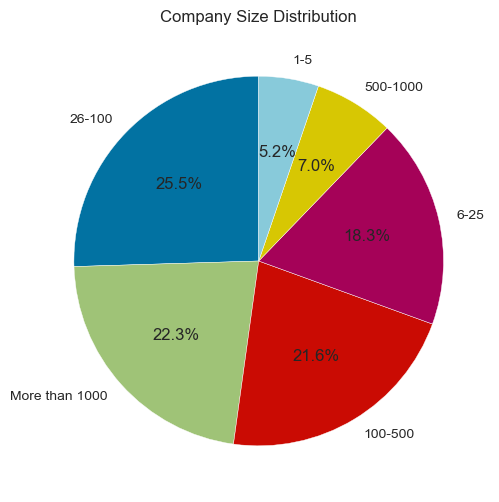

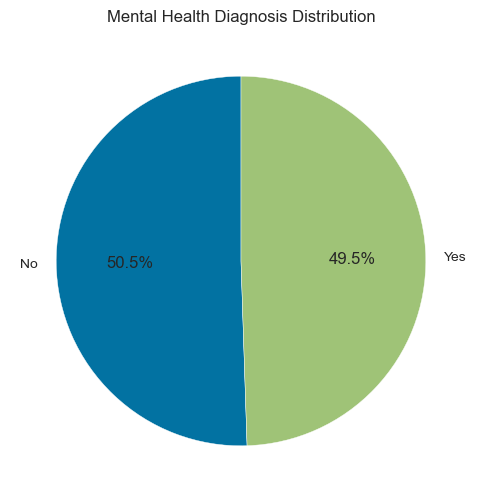

In [308]:
# Visualize the distribution of gender using pie chart
gender_counts = data['gender'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Gender Distribution of Participants')
plt.show()

# Visualize the distribution of company size using pie chart
company_size_counts = data['number_of_employees'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(company_size_counts, labels=company_size_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Company Size Distribution')
plt.show()

# Visualize the distribution of mental health diagnosis using pie chart
diagnosis_counts = data['at_any_point_diagnosed_MH_disorder'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(diagnosis_counts, labels=diagnosis_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Mental Health Diagnosis Distribution')
plt.show()

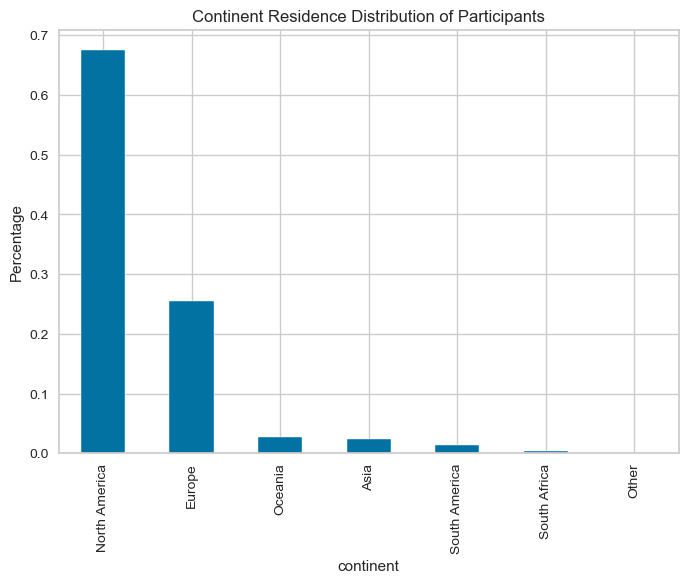

In [309]:
# Visualize the distribution of continent residence based on percentage using a bar chart

# Get the percentage of each continent residence
continent_residence_counts = data['continent_residence'].value_counts(normalize=True)

# Plot the bar chart
continent_residence_counts.plot(kind='bar')
plt.xlabel('continent')
plt.ylabel('Percentage')
plt.title('Continent Residence Distribution of Participants')
plt.show()

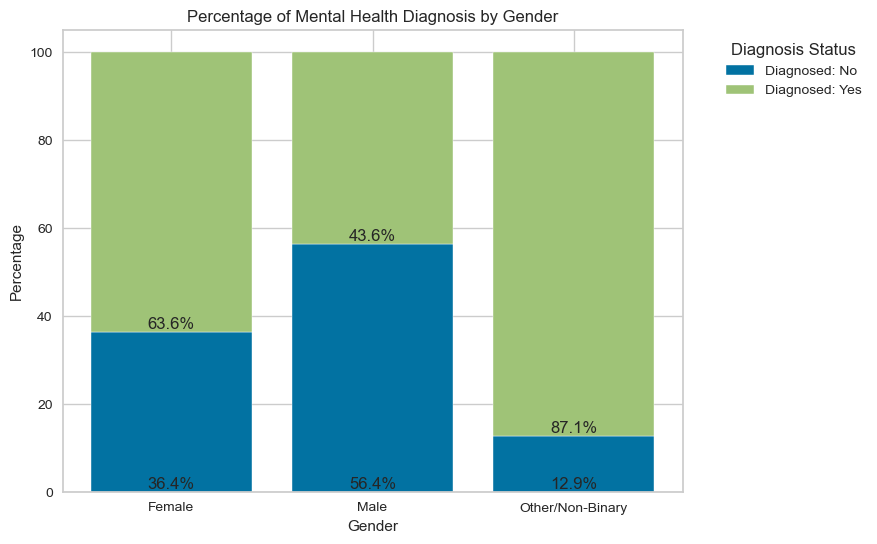

In [310]:
# Group by gender and 'at any point diagnosed mental health disorder'
# Creates a DataFrame where gender is the index and 'at any point diagnosed mental health disorder' is the column. 
grouped_data = data.groupby(['gender', 'at_any_point_diagnosed_MH_disorder']).size().unstack(fill_value=0)

# Calculate the percentage
percentage_data = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each diagnosis status as a separate segment in the stacked bar
for diagnosis in percentage_data.columns:
    ax.bar(
        percentage_data.index,
        percentage_data[diagnosis],
        label=f'Diagnosed: {diagnosis}',
        bottom=percentage_data[percentage_data.columns[:list(percentage_data.columns).index(diagnosis)]].sum(axis=1)
    )

# Customize the chart with key information to the side of the chart
ax.legend(title='Diagnosis Status', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel('Gender')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Mental Health Diagnosis by Gender')

# Annotate each bar with the percentage values
for i in range(len(percentage_data)):
    for j in range(len(percentage_data.columns)):
        plt.text(i, percentage_data.iloc[i, :j].sum(), f'{percentage_data.iloc[i, j]:.1f}%', ha='center', va='bottom')
        
plt.show()

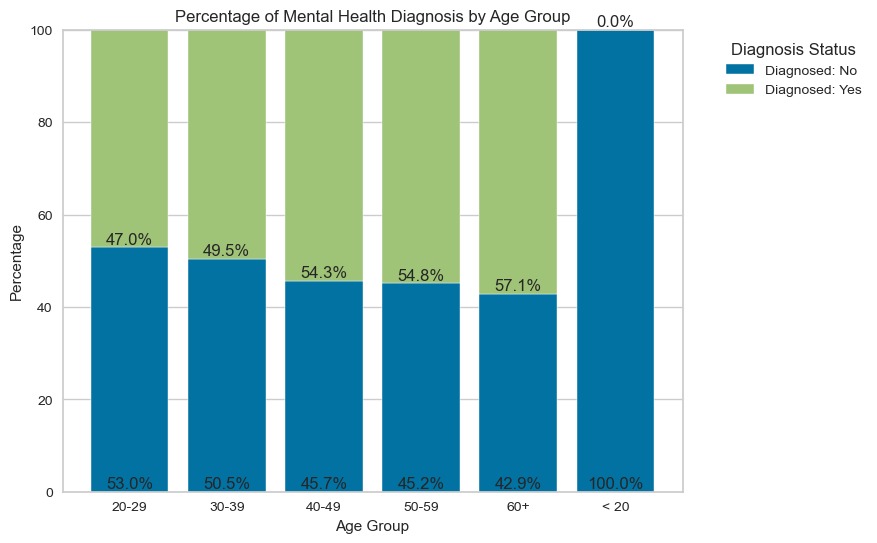

In [311]:
# Group by age and 'at any point diagnosed mental health disorder'
# Creates a DataFrame where age is the index and 'at any point diagnosed mental health disorder' is the column. 
grouped_data = data.groupby(['age_group', 'at_any_point_diagnosed_MH_disorder']).size().unstack(fill_value=0)

# Calculate the percentage
percentage_data = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each diagnosis status as a separate segment in the stacked bar
for diagnosis in percentage_data.columns:
    ax.bar(
        percentage_data.index,
        percentage_data[diagnosis],
        label=f'Diagnosed: {diagnosis}',
        bottom=percentage_data[percentage_data.columns[:list(percentage_data.columns).index(diagnosis)]].sum(axis=1)
    )

# Customize the chart with key information to the side of the chart
ax.legend(title='Diagnosis Status', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel('Age Group')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Mental Health Diagnosis by Age Group')

# Annotate each bar with the percentage values
for i in range(len(percentage_data)):
    for j in range(len(percentage_data.columns)):
        plt.text(i, percentage_data.iloc[i, :j].sum(), f'{percentage_data.iloc[i, j]:.1f}%', ha='center', va='bottom')
        
plt.show()

In [312]:
# Visualization of Cluster Profiles using the top features from PCA and Feature Importance Analysis

# MinMaxScaler
list_of_important_features = ["at_any_point_diagnosed_MH_disorder","treatment_MH_disorder", "past_history_mental_health", "interference_with_work_NOT_effective_treatment", "current_MH_disorder", "family_history_mental_health", "mental_health_benefits", "continent_residence",  "continent_work", "mental_health_coverage_awareness", "interference_with_work_with_effective_treatment", "previous_employer_mental_health_benefits", "gender", "current_employment_less_likely_to_reveal_mental_health_issue", "mental_health_resources"]


In [313]:
# Find the mode of each feature in each cluster in the list_of_important_features

cluster_profiles = data.groupby('cluster')[list_of_important_features].agg(lambda x: x.value_counts().index[0])
cluster_profiles
# Use grouped bar chart to visualize cluster profiles for top features based on PC1 and Feature Importance Analysis

,at_any_point_diagnosed_MH_disorder,treatment_MH_disorder,past_history_mental_health,interference_with_work_NOT_effective_treatment,current_MH_disorder,family_history_mental_health,mental_health_benefits,continent_residence,continent_work,mental_health_coverage_awareness,interference_with_work_with_effective_treatment,previous_employer_mental_health_benefits,gender,current_employment_less_likely_to_reveal_mental_health_issue,mental_health_resources
cluster,,,,,,,,,,,,,,,
0,No,No,No,Not applicable to me,No,No,Yes,North America,North America,No,Not applicable to me,I don't know,Male,Missing,I don't know
1,Yes,Yes,Yes,Often,Yes,Yes,Yes,North America,North America,Yes,Sometimes,Some did,Male,Missing,No
2,No,No,No,Not applicable to me,No,No,No,Europe,Europe,No,Not applicable to me,"No, none did",Male,Missing,No


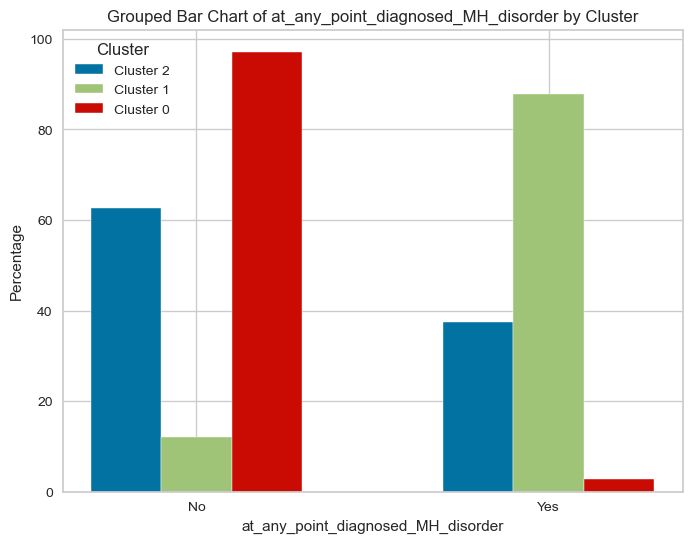

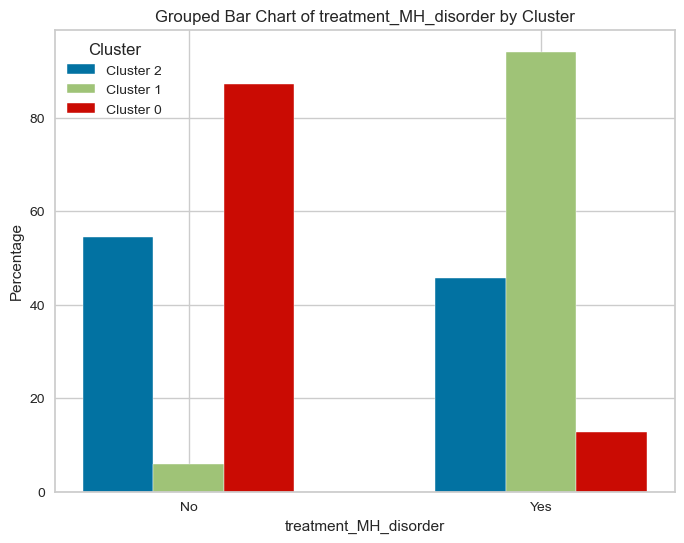

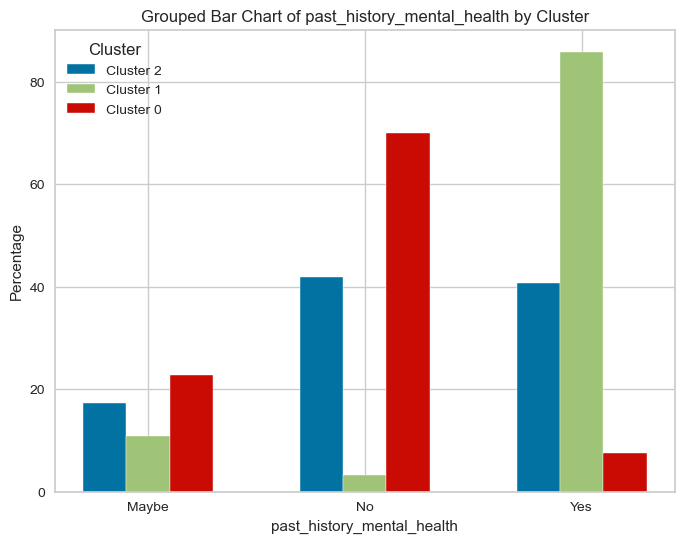

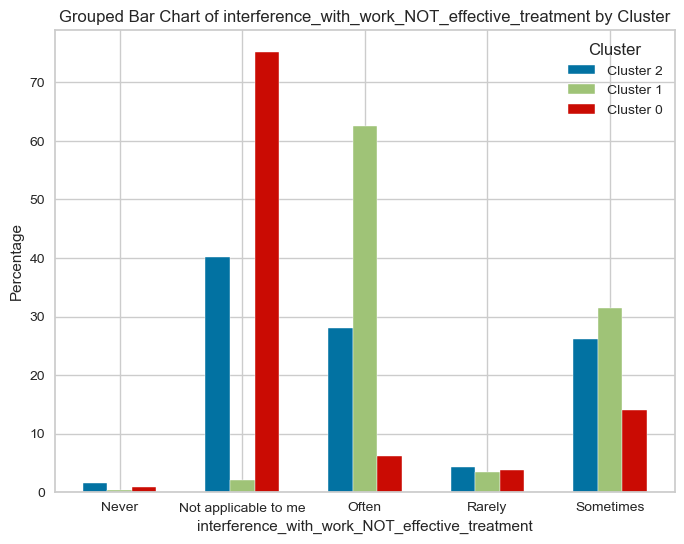

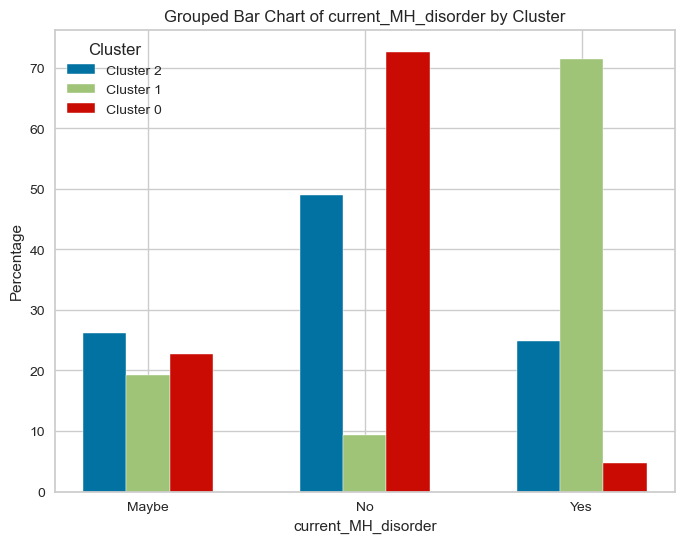

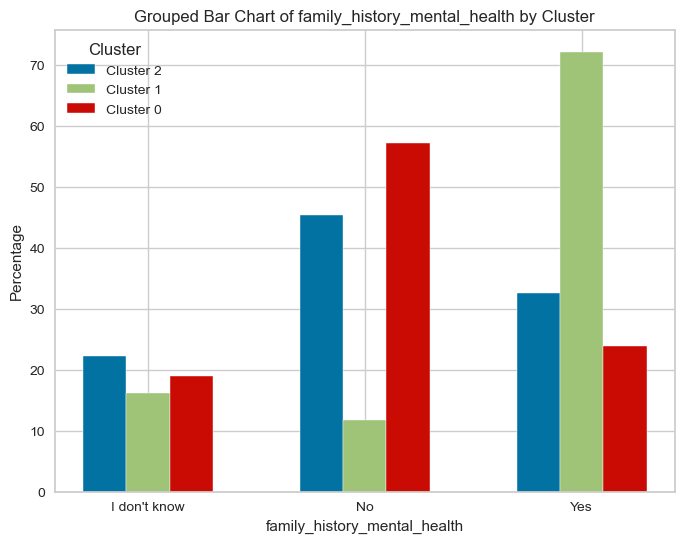

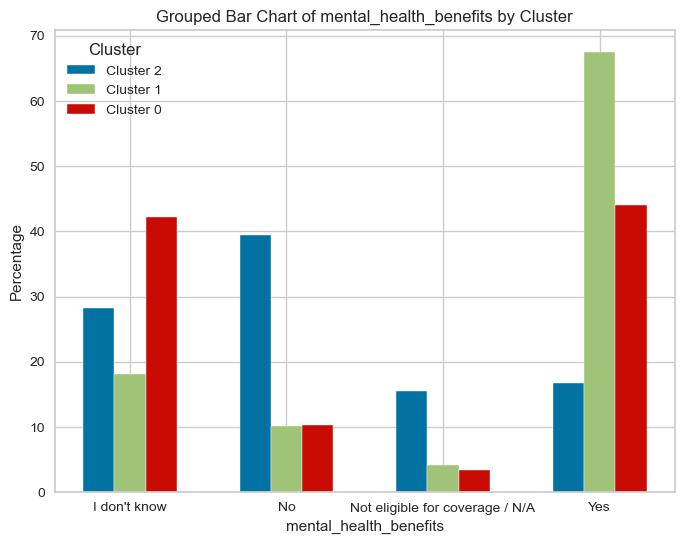

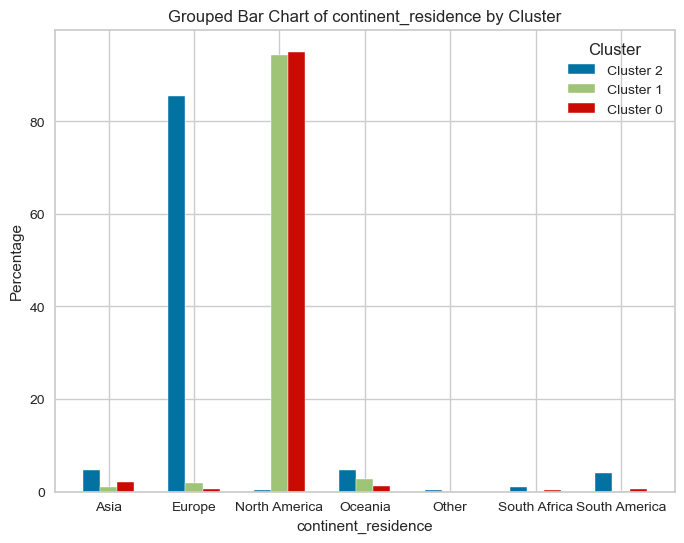

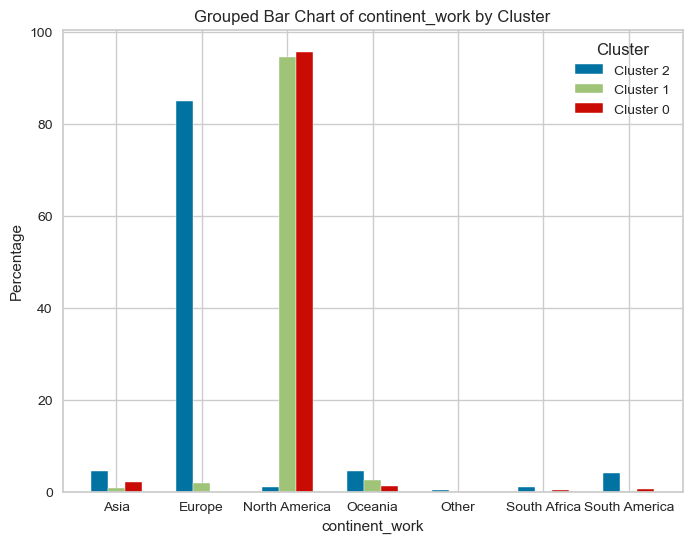

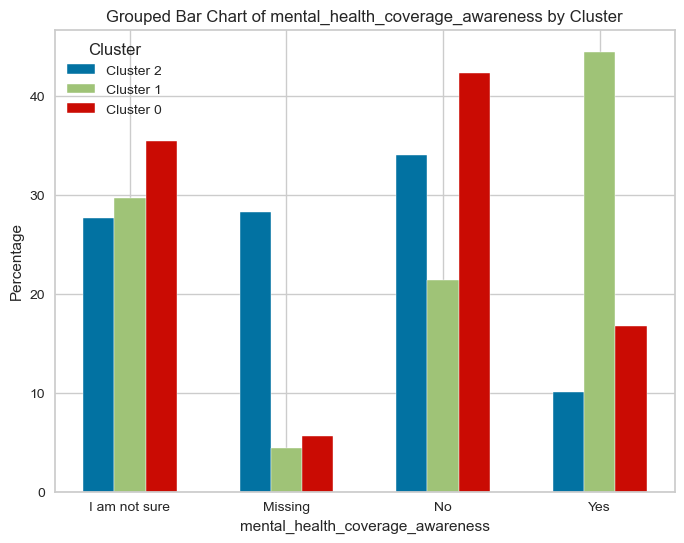

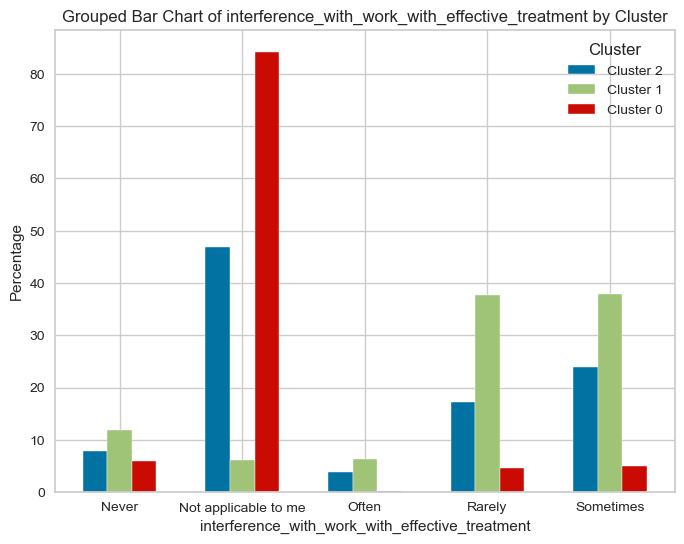

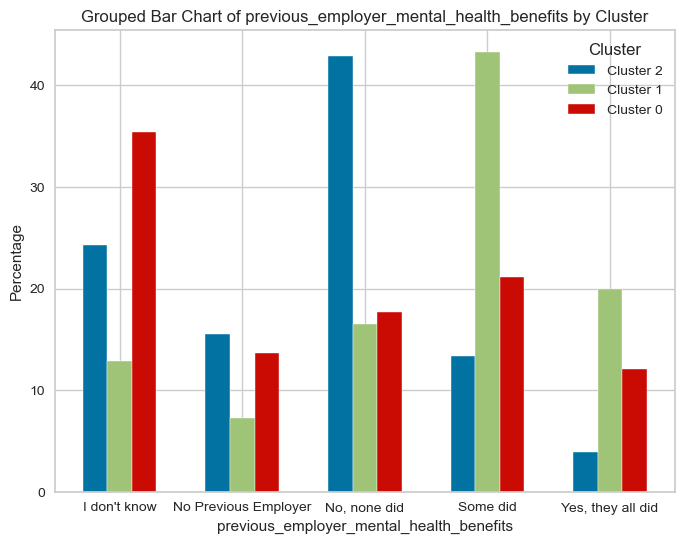

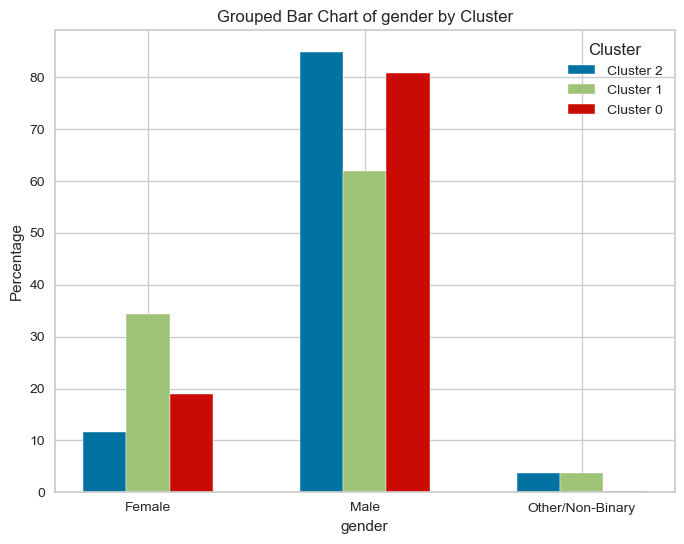

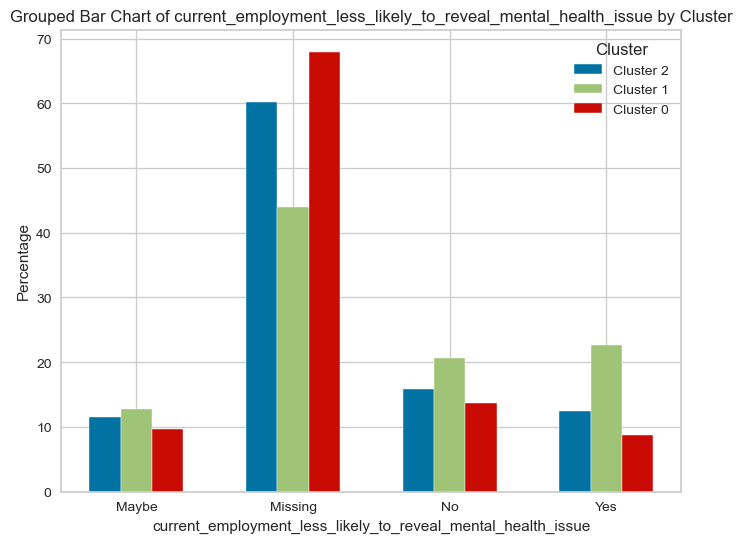

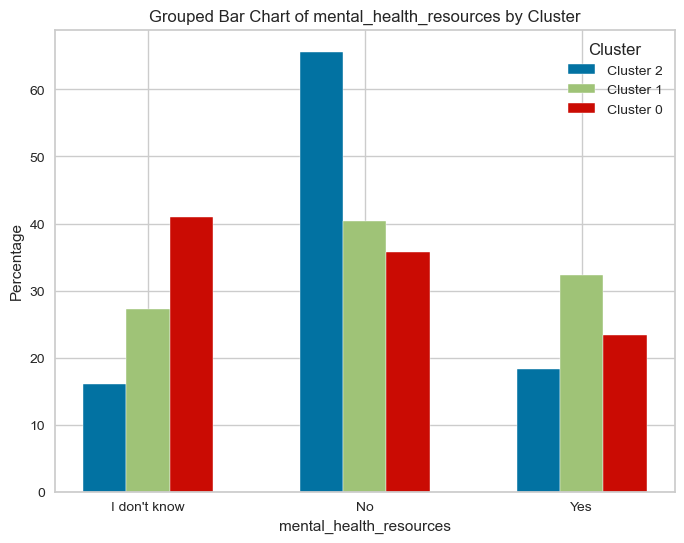

In [314]:
# Use grouped bar chart to visualize cluster profiles for top features based on PCA and Feature Importance Analysis


for feature in list_of_important_features:
    plt.figure(figsize=(8, 6))
    bar_width = 0.2
    clusters = data['cluster'].unique()
    unique_values = np.unique(data[feature])
    indices = np.arange(len(unique_values))

    for i, cluster in enumerate(clusters):
        cluster_data = data[data['cluster'] == cluster][feature]
        values, counts = np.unique(cluster_data, return_counts=True)
        percentages = np.zeros(len(unique_values))
        for j, val in enumerate(unique_values):
            if val in values:
                percentages[j] = counts[values == val][0] / counts.sum() * 100  # Extract single element
        plt.bar(indices + i * bar_width, percentages, bar_width, label=f'Cluster {cluster}')

    plt.title(f'Grouped Bar Chart of {feature} by Cluster')
    plt.xlabel(feature)
    plt.ylabel('Percentage')
    plt.xticks(indices + bar_width * (len(clusters) - 1) / 2, unique_values)
    plt.legend(title='Cluster')

    plt.show() 

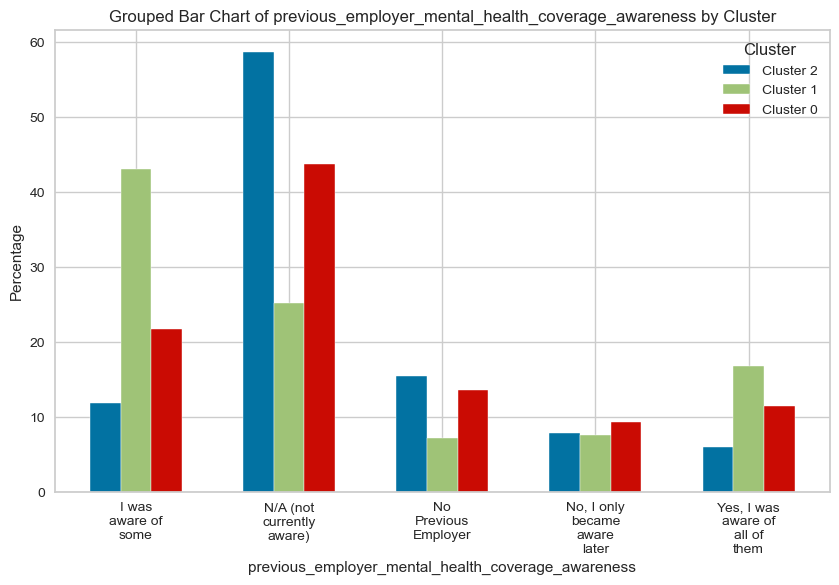

In [315]:
# Improve labeling of previous_employer_mental_health_coverage_awareness due to overlapping x-axis labels

# Feature to plot
feature = 'previous_employer_mental_health_coverage_awareness'

# Prepare data for the grouped bar chart
bar_width = 0.2
clusters = data['cluster'].unique()
unique_values = np.unique(data[feature])
indices = np.arange(len(unique_values))

# Create the plot
plt.figure(figsize=(10, 6))

for i, cluster in enumerate(clusters):
    cluster_data = data[data['cluster'] == cluster][feature]
    values, counts = np.unique(cluster_data, return_counts=True)
    percentages = np.zeros(len(unique_values))
    for j, val in enumerate(unique_values):
        if val in values:
            percentages[j] = counts[values == val][0] / counts.sum() * 100  # Extract single element
    plt.bar(indices + i * bar_width, percentages, bar_width, label=f'Cluster {cluster}')

# Wrap x-axis labels
wrapped_labels = [textwrap.fill(label, 10) for label in unique_values]

# Customize the plot
plt.title(f'Grouped Bar Chart of {feature} by Cluster')
plt.xlabel(feature)
plt.ylabel('Percentage')
plt.xticks(indices + bar_width * (len(clusters) - 1) / 2, wrapped_labels)
plt.legend(title='Cluster')

# Show the plot
plt.show()
